# Clasificadores Binarios

utilizaremos los siguientes clasificadores:

* K-NN
* arbol de decision
* SVC
* regresion logistica
* MLP

El dataset utilizado esl el 'dataset1' que contiene mediciones a las 14 y 19 hrs, el cual normalizamos en un intervalo [0,1]

Ademas se equilibia la cantidad de datos, borrando mediciones

In [245]:
import glob
import pandas as pd
import numpy as np
from datetime import date, datetime, time, timedelta
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import matplotlib.pyplot as plt


from sklearn import preprocessing
import seaborn as sns
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [108]:
data = "../data/processed/dataset1.csv"
df = pd.read_csv(data)
df.head()

,code,Fecha,T_14,Hum_14,DVin_14,VVin_14,Prec_14,RadSol_14,PATM_14h,T_19,Hum_19,DVin_19,VVin_19,Prec_19,RadSol_19,PATM_19h,Target
0,13,2010-06-11,7.2,66.7,61.4,0.0,0.0,146.0,1006.0,3.8,84.7,146.5,0.0,0.0,0.0,1005.0,True
1,13,2010-06-12,14.0,48.6,315.7,0.0,0.0,246.3,1008.0,9.7,66.0,266.1,0.0,0.0,0.0,1013.0,False
2,13,2010-06-13,8.6,82.4,228.0,0.0,0.0,118.5,1011.0,6.3,95.5,141.3,0.0,0.0,0.0,1011.0,False
3,13,2010-06-14,6.0,84.9,53.2,0.0,0.2,53.6,1014.0,3.7,94.2,114.6,0.0,0.4,0.0,1019.0,False
4,13,2010-06-15,0.8,89.7,240.3,0.0,0.0,39.6,1026.0,0.7,89.3,144.7,0.0,0.0,0.0,1027.0,True


In [243]:
# debemos equilibrar la cantidad de datos, por ahora lo que haremos sera reducir dias no helados.
idxs = df[df["Target"] == False].index
choices = np.random.choice(idxs, 6000)
choices = np.unique(choices)
df_nofrost = df.iloc[choices]
df_frost = df[df["Target"]]
print("luego de emparejar, tenemos:")
print(len(df_nofrost), "dias sin heladas")
print(len(df_frost), "dias con heladas")

df_fix = pd.concat([df_frost, df_nofrost])
df_fix.head()

luego de emparejar, tenemos:
5649 dias sin heladas
3005 dias con heladas


,code,Fecha,T_14,Hum_14,DVin_14,VVin_14,Prec_14,RadSol_14,PATM_14h,T_19,Hum_19,DVin_19,VVin_19,Prec_19,RadSol_19,PATM_19h,Target
0,13,2010-06-11,7.2,66.7,61.4,0.0,0.0,146.0,1006.0,3.8,84.7,146.5,0.0,0.0,0.0,1005.0,True
4,13,2010-06-15,0.8,89.7,240.3,0.0,0.0,39.6,1026.0,0.7,89.3,144.7,0.0,0.0,0.0,1027.0,True
5,13,2010-06-16,2.3,70.2,183.1,0.0,0.0,278.3,1023.0,0.2,69.1,271.2,0.0,0.0,0.0,1025.0,True
6,13,2010-06-17,4.1,57.9,259.1,0.0,0.0,326.6,1027.0,-2.3,84.8,98.9,0.0,0.0,0.0,1031.0,True
7,13,2010-06-18,4.7,59.6,299.3,0.0,0.0,203.4,1020.0,-1.8,92.8,206.0,0.0,0.0,0.0,1022.0,True


In [222]:
matrix = df_fix.values
X = matrix[:,2:-1]
y = matrix[:,-1].astype(float)

In [223]:
# normalize data
X_scaled = preprocessing.scale(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1, stratify=y)

# KNN

In [224]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train) 
print("Score KNN:", knn.score(X_test, y_test))

Score KNN: 0.8799126637554585


In [225]:

#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=10)
#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X, y, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.68340611 0.68195051 0.71615721 0.73508006 0.67443554]
cv_scores mean:0.6982058858140622


In [226]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, knn.predict(X_test)))
print(classification_report(y_test, knn.predict(X_test)))

[[674  99]
 [ 66 535]]
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89       773
         1.0       0.84      0.89      0.87       601

    accuracy                           0.88      1374
   macro avg       0.88      0.88      0.88      1374
weighted avg       0.88      0.88      0.88      1374



In [227]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

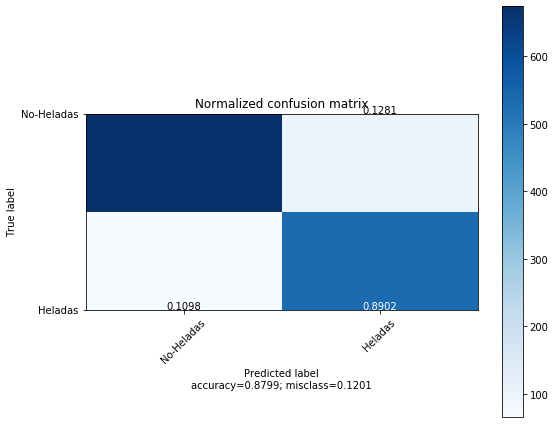

In [228]:
cm = confusion_matrix(y_test, knn.predict(X_test))
plot_confusion_matrix(cm, ["No-Heladas", "Heladas"], normalize=True,
                      title='Normalized confusion matrix')

## ARBOL DE DESICION


In [229]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_leaf=20)
clf = clf.fit(X_train, y_train)

In [230]:
clf.score(X_test, y_test)

0.8646288209606987

In [231]:
clf_cv = tree.DecisionTreeClassifier()
#train model with cv of 5 
cv_scores = cross_val_score(clf_cv, X, y, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.76491994 0.85371179 0.81659389 0.81950509 0.78514202]
cv_scores mean:0.8079745476018578


# REGRESION LOGISTICA

In [232]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8609898107714702

In [233]:
logreg_cv = LogisticRegression()
#train model with cv of 5 
cv_scores = cross_val_score(logreg_cv, X, y, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.87700146 0.85080058 0.85225619 0.8580786  0.80772032]
cv_scores mean:0.8491714294498495


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# SVC

In [234]:
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

/usr/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9002911208151383

In [235]:
svc_cv = SVC(probability=True)
#train model with cv of 5 
cv_scores = cross_val_score(svc_cv, X, y, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

/usr/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will chan

[0.56331878 0.56331878 0.56259098 0.56259098 0.5622724 ]
cv_scores mean:0.5628183802614575


# MLP

In [236]:
from sklearn.neural_network import MLPClassifier
reg = MLPClassifier(hidden_layer_sizes=(100), alpha=0.01, max_iter=1000, early_stopping=True)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.8901018922852983

In [237]:
reg_cv = MLPClassifier(hidden_layer_sizes=(500), alpha=0.001, max_iter=1000, early_stopping=True)
#train model with cv of 5 
cv_scores = cross_val_score(reg_cv, X, y, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.84788937 0.85080058 0.84352256 0.85371179 0.798252  ]
cv_scores mean:0.8388352623002785


In [238]:
print(confusion_matrix(y_test, reg.predict(X_test)))
print(classification_report(y_test, reg.predict(X_test)))

[[690  83]
 [ 68 533]]
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       773
         1.0       0.87      0.89      0.88       601

    accuracy                           0.89      1374
   macro avg       0.89      0.89      0.89      1374
weighted avg       0.89      0.89      0.89      1374



# analisis de resultados

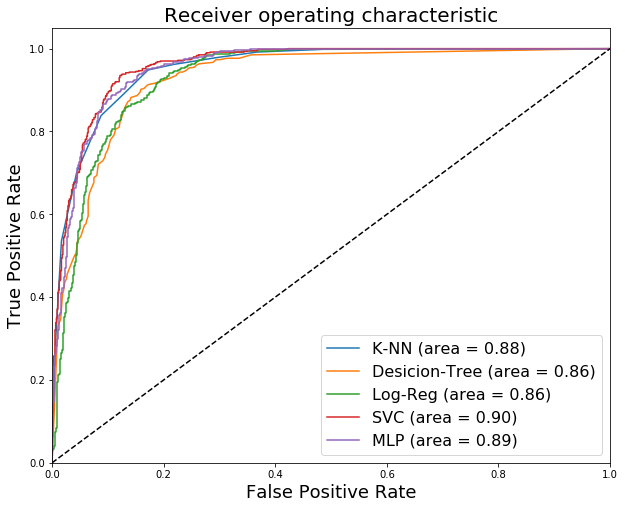

In [239]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.figure(figsize=(10,8))
for classifier, label in zip([knn, clf, logreg, svc, reg],
                            ["K-NN", "Desicion-Tree", "Log-Reg", "SVC", "MLP"]):
    cl_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (label,cl_roc_auc))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('Log_ROC')
plt.show()
    

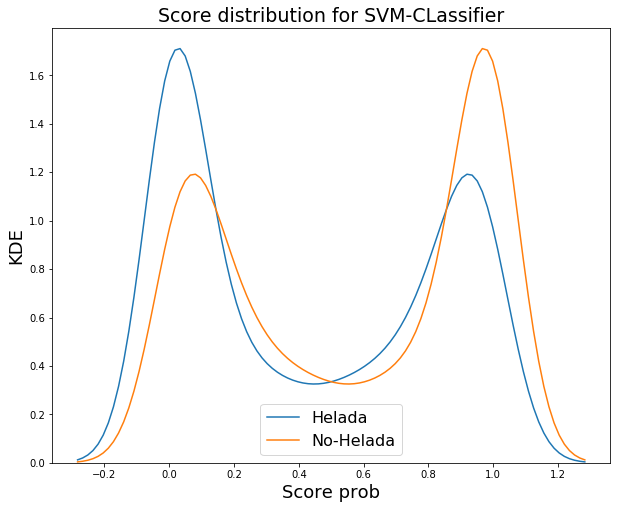

In [273]:
plt.figure(figsize=(10, 8))
sns.kdeplot(svc.predict_proba(X_test)[:,1], kernel="gau", label="Helada")
# plt.hist(reg.predict_proba(X_test)[:,1], normed=True)
sns.kdeplot(svc.predict_proba(X_test)[:,0], kernel="gau", label="No-Helada")
# plt.hist(reg.predict_proba(X_test)[:,0], normed=True)

plt.xlabel("Score prob", fontsize=18)
plt.ylabel("KDE", fontsize=18)
plt.title("Score distribution for SVM-CLassifier", fontsize=19)
plt.legend(fontsize=16)

In [242]:
(logreg.predict_proba(X_test)[:,1] > 0.9).astype(int)

array([0, 0, 0, ..., 0, 1, 0])